In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

In [2]:
from google.colab import files

uploaded = files.upload()

Saving 건대입구역_최종데이터.csv to 건대입구역_최종데이터.csv


In [4]:
# Assuming you uploaded a CSV file
filename = next(iter(uploaded))

In [5]:
df = pd.read_csv('건대입구역_최종데이터.csv')

In [7]:
# Display first few rows of the data
print(df.head())

# Summary of the data
print(df.describe())

# Columns to remove
cols_to_remove = ["Relative_Humidity", "cue", "Commute", "승하차", "Boarding_Alighting", "Transport_Date", "Station_Name"]

# Splitting the dataframe into four based on 'Commute' and '승하차' conditions
출근승차 = df[(df['Commute'] == 1) & (df['승하차'] == 1)].drop(columns=cols_to_remove)
출근하차 = df[(df['Commute'] == 1) & (df['승하차'] == 0)].drop(columns=cols_to_remove)
퇴근승차 = df[(df['Commute'] == 0) & (df['승하차'] == 1)].drop(columns=cols_to_remove)
퇴근하차 = df[(df['Commute'] == 0) & (df['승하차'] == 0)].drop(columns=cols_to_remove)

  Transport_Date Station_Name Boarding_Alighting  Passenger_Count  Typhoon  \
0       2022.1.1         건대입구                 승차              362        0   
1       2022.1.1         건대입구                 하차              180        0   
2       2022.1.1         건대입구                 승차             1606        0   
3       2022.1.1         건대입구                 하차             2758        0   
4       2022.1.2         건대입구                 승차              346        0   

   Heatwave  Temperature  Precipitation  Relative_Humidity  Commute  ...  \
0         0        -10.1            0.0                  0        1  ...   
1         0        -10.1            0.0                  0        1  ...   
2         0         -0.9            0.0                  0        0  ...   
3         0         -0.9            0.0                  0        0  ...   
4         0         -2.2            0.0                  0        1  ...   

   일월날짜  승하차  cue  습도   적설  파업  IsHoliday  이전 승하차수  일주일 전 승하차 수  잠실 스포츠  


In [8]:
# If you need to see the first few rows of each dataframe
print(출근승차.head())


    Passenger_Count  Typhoon  Heatwave  Temperature  Precipitation  월요일  화요일  \
0               362        0         0        -10.1            0.0    0    0   
4               346        0         0         -2.2            0.0    0    0   
9              1989        0         0         -7.7            0.0    1    0   
13             1958        0         0         -4.0            0.0    0    1   
20             1957        0         0         -5.5            0.0    0    0   

    수요일  목요일  금요일  토요일  일월날짜  습도   적설  파업  IsHoliday  이전 승하차수  일주일 전 승하차 수  \
0     0    0    0    1     1  53  0.0   0          1      362          362   
4     0    0    0    0     2  66  0.1   0          0     2758          346   
9     0    0    0    0     3  55  0.0   0          0      952         1606   
13    0    0    0    0     4  73  0.0   0          0      953         2878   
20    0    1    0    0     6  60  0.0   0          0     2404         1958   

    잠실 스포츠  
0        0  
4        0  
9        0 

In [9]:
print(출근하차.head())
print(퇴근승차.head())
print(퇴근하차.head())

    Passenger_Count  Typhoon  Heatwave  Temperature  Precipitation  월요일  화요일  \
1               180        0         0        -10.1            0.0    0    0   
5               187        0         0         -2.2            0.0    0    0   
8               952        0         0         -7.7            0.0    1    0   
12              953        0         0         -4.0            0.0    0    1   
16              999        0         0         -7.7            0.0    0    0   

    수요일  목요일  금요일  토요일  일월날짜  습도   적설  파업  IsHoliday  이전 승하차수  일주일 전 승하차 수  \
1     0    0    0    1     1  53  0.0   0          1      362          180   
5     0    0    0    0     2  66  0.1   0          0      346          187   
8     0    0    0    0     3  55  0.0   0          0     1689          180   
12    0    0    0    0     4  73  0.0   0          0     2182          187   
16    1    0    0    0     5  55  0.0   0          0     2302         1989   

    잠실 스포츠  
1        0  
5        0  
8        0 

## 파라미터 조정 없는 기본 모델

497
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 497, number of used features: 15
[LightGBM] [Info] Start training from score 1655.820926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

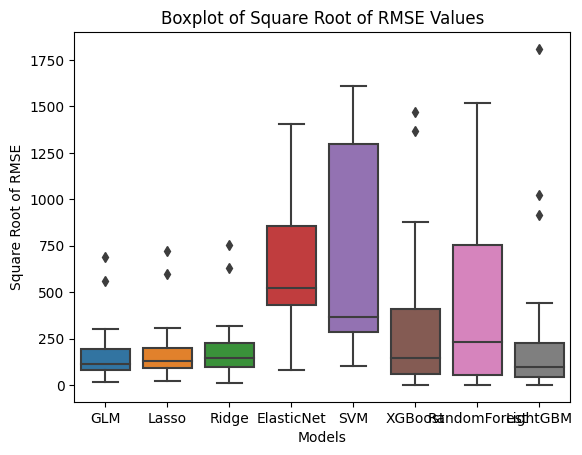

In [13]:
data = 출근승차

# Set the window size and prediction horizon
window_size = len(data) - 100
predict_ahead = 1



# Initialize a list to store predictions and errors
rmse_list = []

# Loop over the data using a rolling window approach
for i in range(window_size, 530):
    print(i)

    # Partition the data
    train_data = data.iloc[:i]
    test_data = data.iloc[i:i+predict_ahead]

    X_train = train_data.drop('Passenger_Count', axis=1)
    y_train = train_data['Passenger_Count']
    X_test = test_data.drop('Passenger_Count', axis=1)
    y_test = test_data['Passenger_Count']

    # Initialize a dictionary to store models and errors
    models = {'GLM': LinearRegression(),
              'Lasso': Lasso(),
              'Ridge': Ridge(),
              'ElasticNet': ElasticNet(),
              'SVM': SVR(),
              'XGBoost': XGBRegressor(objective='reg:squarederror'),
              'RandomForest': RandomForestRegressor(n_estimators=500),
              'LightGBM': LGBMRegressor()}

    errors = []

    # Train and evaluate each model
    for model_name, model in models.items():
        # For SVM, XGBoost, RandomForest, LightGBM, you might need to tune hyperparameters
        # using GridSearchCV or a similar approach

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        errors.append(mse)

    # Store RMSE for each model
    rmse_list.append(np.sqrt(errors))

# Calculate and plot the RMSE for each model
rmse_df = pd.DataFrame(rmse_list, columns=models.keys())
print(rmse_df.describe())

# For plotting, you can use matplotlib or seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=rmse_df)
plt.title('Boxplot of Square Root of RMSE Values')
plt.xlabel('Models')
plt.ylabel('Square Root of RMSE')
plt.show()

## randomforest, lightgbm 파라미터 조정

In [ ]:
# Set the window size and prediction horizon
window_size = len(data) - 100
predict_ahead = 1

# Initialize a list to store RMSE for each model
rmse_list = []

# Parameter grids for Grid Search
param_grid_lgbm = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Loop over the data using a rolling window approach
for i in range(window_size, 530):
    # Partition the data
    train_data = data.iloc[:i]
    test_data = data.iloc[i:i+predict_ahead]

    X_train = train_data.drop('Passenger_Count', axis=1)
    y_train = train_data['Passenger_Count']
    X_test = test_data.drop('Passenger_Count', axis=1)
    y_test = test_data['Passenger_Count']

    # Initialize models with base parameters
    models = {
        'XGBoost': XGBRegressor(objective='reg:squarederror'),
        'LightGBM': LGBMRegressor(),
        'RandomForest': RandomForestRegressor()
    }

    errors = []

    # Train and evaluate each model
    for model_name, model in models.items():
        if model_name == 'LightGBM':
            grid_search = GridSearchCV(model, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        elif model_name == 'RandomForest':
            grid_search = GridSearchCV(model, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = model.fit(X_train, y_train)

        predictions = best_model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        errors.append(mse)

    # Store RMSE for each model
    rmse_list.append(np.sqrt(errors))

# Calculate and plot the RMSE for each model
rmse_df = pd.DataFrame(rmse_list, columns=models.keys())

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=rmse_df)
plt.title('Boxplot of Square Root of RMSE Values')
plt.xlabel('Models')
plt.ylabel('Square Root of RMSE')
plt.show()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 